In [63]:
import pandas as pd 
from ast import literal_eval

In [64]:
def create_df(df):
  df = df[df['is_answerable'] == 1].copy()
  df = df[df['questionText'].apply(lambda x:len(x.split()) < 30)]
  df['review_snippets'] = df['review_snippets'].apply(lambda x: '    '.join(literal_eval(x)))  #4 spaces 
  df['answers'] = df['answers'].apply(lambda x: [text.get('answerText') for text in literal_eval(x)])
  df = df[['questionText','review_snippets','answers']]
  df.columns = ['Question','Context','Answer']
  return df.explode('Answer').drop_duplicates('Context').reset_index(drop=True)


In [ ]:
reviews = create_df(reviews)
reviews['Type'] = 'reviews'

In [ ]:
reviews =reviews.sample(frac=1).iloc[:10000]

In [ ]:
dfs = []
df = pd.read_csv('../Data/Q_and_A.csv')
for i in range(1,12):
    dfs.append(pd.read_csv(f'../Data/q_and_a ({i}).csv'))

df = pd.concat(dfs + [df], ignore_index=True)[['Context','Question', 'Answer']].drop_duplicates(subset=['Context']).drop_duplicates(subset=['Question'])
df['Type'] ='Synthetic'

In [ ]:
import datasets
from datasets import load_dataset


In [66]:
dataset = load_dataset("duorc",'ParaphraseRC')
duorc = pd.concat([dataset['train'].to_pandas()] + [dataset['validation'].to_pandas()] + [dataset['test'].to_pandas()])
duorc = duorc[~duorc['no_answer']][['plot','question','answers']]
duorc['answers'] = duorc['answers'].apply(lambda x: x[0])
duorc.columns = ['Context','Question','Answer']
duorc = duorc.drop_duplicates(subset=['Context']).drop_duplicates(subset=['Question'])
duorc['Type'] ='duorc'

Found cached dataset duorc (/Users/weihern/.cache/huggingface/datasets/duorc/ParaphraseRC/1.0.0/7a96356b7615d573abcd03a9328292c38348547971989538a771c32089bff199)


  0%|          | 0/3 [00:00<?, ?it/s]

In [67]:
dataset = load_dataset("narrativeqa")

Found cached dataset narrativeqa (/Users/weihern/.cache/huggingface/datasets/narrativeqa/default/0.0.0/daef7ccc51ec258bef464658d11751bb20f033da9b4c219fd84563b3a4af0422)


  0%|          | 0/3 [00:00<?, ?it/s]

In [68]:
narrativeqa = pd.concat([dataset['train'].to_pandas()] + [dataset['validation'].to_pandas()] + [dataset['test'].to_pandas()])
narrativeqa['document'] = narrativeqa['document'].apply(lambda x: x['summary']['text'])
narrativeqa['question'] = narrativeqa['question'].apply(lambda x: x['text'])
narrativeqa['answers'] = narrativeqa['answers'].apply(lambda x: x[0]['text'])
narrativeqa.columns = ['Context','Question','Answer']
narrativeqa = narrativeqa.drop_duplicates(subset=['Context']).drop_duplicates(subset=['Question'])
narrativeqa['Type'] ='narrativeqa'

In [43]:
import nltk

<AxesSubplot: >

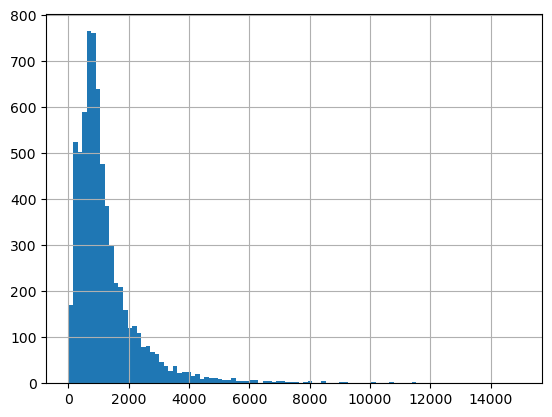

In [44]:
duorc['Context'].apply(lambda x: len(nltk.tokenize.word_tokenize(x))).hist(bins = 100)

<AxesSubplot: >

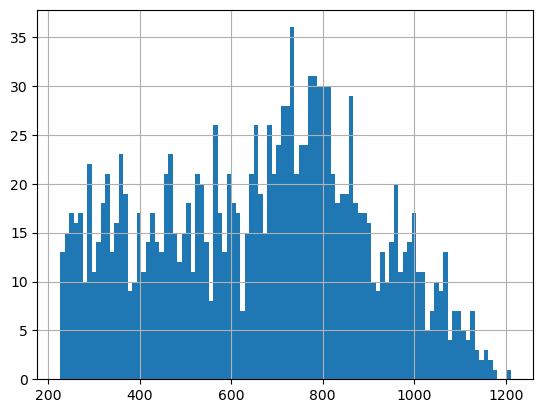

In [45]:
narrativeqa['Context'].apply(lambda x: len(nltk.tokenize.word_tokenize(x))).hist(bins = 100)

In [46]:
subjqa = pd.read_csv('../Data/subjqa.csv')
subjqa.columns = ['Context','Question','Answer']
subjqa = subjqa.drop_duplicates(subset=['Context']).drop_duplicates(subset=['Question'])
subjqa['Type'] ='subjqa'

In [47]:
ms_marco = pd.read_csv('../Data/ms_marco.csv')
ms_marco['Type'] ='ms_marco'

In [48]:
master = pd.concat([df,duorc,narrativeqa,subjqa,ms_marco,reviews], ignore_index=True).dropna()

In [49]:
master['Type'].value_counts()

Synthetic      12554
ms_marco       10790
reviews        10000
duorc           6790
subjqa          2750
narrativeqa     1544
Name: Type, dtype: int64

In [50]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, AdamW

In [51]:
tokenizer = T5Tokenizer.from_pretrained('t5-large')

/Users/weihern/opt/anaconda3/envs/ml/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [52]:
from tqdm import tqdm

In [53]:
token_lens = []
for text in tqdm(master['Context']):
    tokens = tokenizer(text).input_ids
    token_lens.append(len(tokens))

100%|██████████| 44428/44428 [01:07<00:00, 658.71it/s] 


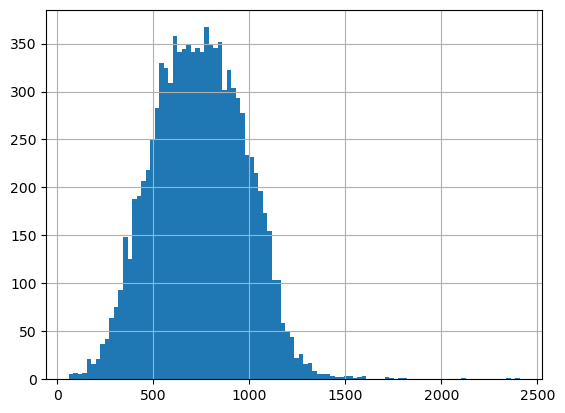

In [54]:
r = reviews['Context'].apply(lambda x: len(nltk.tokenize.word_tokenize(x))).hist(bins = 100)

In [55]:
master['token_lens'] = token_lens

In [56]:
master = master[master['token_lens'] < 512]

In [57]:
from sklearn.model_selection import train_test_split

In [58]:
train_df, test_df = train_test_split(master, test_size=0.2, random_state=42,stratify=master['Type'])

In [59]:
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42,stratify=test_df['Type'])

In [60]:
def compile_datasets(df,name):
    df.drop(['token_lens','Type'], axis = 1, inplace = True)
    df.reset_index(inplace = True, drop = True)
    df.to_csv(f'../Data/{name}.csv', index = False)
    print(len(df))

In [61]:
compile_datasets(train_df,'train')
compile_datasets(test_df,'test')
compile_datasets(val_df,'val')

22318
2790
2790
